# 3.8 Gloss Noise Flagging and Vocabulary Filtering (ISL_CLSRT)

This notebook helps flag potential issues in gloss labels to support quality control for sign language datasets.  
We identify:
- Rare gloss tokens (low frequency)
- Sentence-gloss mismatches
- Abnormal gloss lengths

✅ Useful for identifying noisy samples in low-resource or manual annotation settings.


In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

df = pd.read_csv('/content/drive/MyDrive/IETGenAI-SLT/Chapter 4/isl_train_meta.csv')
df = df.dropna(subset=['Sentences', 'gloss_sequence']).drop_duplicates()


In [4]:
df['sentence_len'] = df['Sentences'].apply(lambda x: len(str(x).split()))
df['gloss_len'] = df['gloss_sequence'].apply(lambda x: len(str(x).split()))
df['length_diff'] = df['sentence_len'] - df['gloss_len']


## Gloss Vocabulary and Frequency

In [5]:
gloss_tokens = ' '.join(df['gloss_sequence'].dropna()).split()
gloss_freq = Counter(gloss_tokens)
print(f'Total Unique Gloss Tokens: {len(gloss_freq)}')
gloss_freq.most_common(10)


Total Unique Gloss Tokens: 153


[('YOU', 211),
 ('I', 161),
 ('DO', 55),
 ('WHAT', 41),
 ('DONOT', 34),
 ('IT', 31),
 ('HOW', 31),
 ('HELP', 24),
 ('ME', 21),
 ('NOT', 21)]

## Flag Samples with Rare Gloss Tokens

In [6]:
rare_tokens = {k for k, v in gloss_freq.items() if v == 1}

def contains_rare(gloss):
    tokens = str(gloss).split()
    return any(token in rare_tokens for token in tokens)

df['has_rare_token'] = df['gloss_sequence'].apply(contains_rare)
df[df['has_rare_token']].head()


,Sentences,File location,gloss_sequence,signer_id,sample_id,sentence_len,gloss_len,length_diff,has_rare_token
177,i am feeling bored,ISL_CSLRT_Corpus\Videos_Sentence_Level\i am fe...,I FEEL BORED,5,ISL_0159_S5,4,3,1,True
423,what have you planned for your career,ISL_CSLRT_Corpus\Videos_Sentence_Level\what ha...,YOU PLAN CAREER WHAT,4,ISL_0402_S4,7,4,3,True
483,hi how are you,ISL_CSLRT_Corpus\Videos_Sentence_Level\hi how ...,HI HOW YOU,5,ISL_0116_S5,4,3,1,True


## Flag Length Mismatch Outliers

In [7]:
# Mark rows with large difference between sentence and gloss lengths
df['large_mismatch'] = df['length_diff'].abs() > 5
df[df['large_mismatch']].head()


,Sentences,File location,gloss_sequence,signer_id,sample_id,sentence_len,gloss_len,length_diff,has_rare_token,large_mismatch


In [8]:
df[['Sentences', 'gloss_sequence', 'length_diff', 'has_rare_token', 'large_mismatch']].to_csv('flagged_gloss_samples.csv', index=False)
print("Flagged samples saved to 'flagged_gloss_samples.csv'")


Flagged samples saved to 'flagged_gloss_samples.csv'


# Task
Enhance the provided notebook to include more advanced flagging methods for potential issues in the sentence-gloss pairs. Specifically, implement a keyword matching approach to identify sentence-gloss mismatches, visualize the distribution of length differences between sentences and glosses, visualize the distribution of flagged samples based on rare tokens and large mismatches, and save the updated flagged samples to a new CSV file.

## Identify potential sentence-gloss mismatches using a simple keyword matching approach

### Subtask:
Identify potential sentence-gloss mismatches by checking if keywords from the sentence are present in the corresponding gloss sequence, excluding common stop words.


In [9]:
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
    'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
    'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
    'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
    'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should',
    "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
    'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't'"])

def check_keyword_mismatch(sentence, gloss):
    sentence_tokens = str(sentence).lower().split()
    gloss_tokens = str(gloss).lower().split()
    sentence_keywords = [word for word in sentence_tokens if word not in stop_words]
    return not any(keyword in gloss_tokens for keyword in sentence_keywords)

df['keyword_mismatch'] = df.apply(lambda row: check_keyword_mismatch(row['Sentences'], row['gloss_sequence']), axis=1)
display(df[['Sentences', 'gloss_sequence', 'keyword_mismatch']].head())

,Sentences,gloss_sequence,keyword_mismatch
0,it does not make any difference to me,IT MAKE ANY DIFFERENCE ME DO NOT,False
1,tell me truth,TELL TRUTH,False
2,do me a favour,DO FAVOUR ME,False
3,do not worry,DONOT WORRY,False
4,do not abuse him,HIM ABUSE DONOT,False


## Visualize the distribution of length differences

### Subtask:
Create a histogram to visualize the distribution of the `length_diff` column to understand the extent of length discrepancies between sentences and glosses.


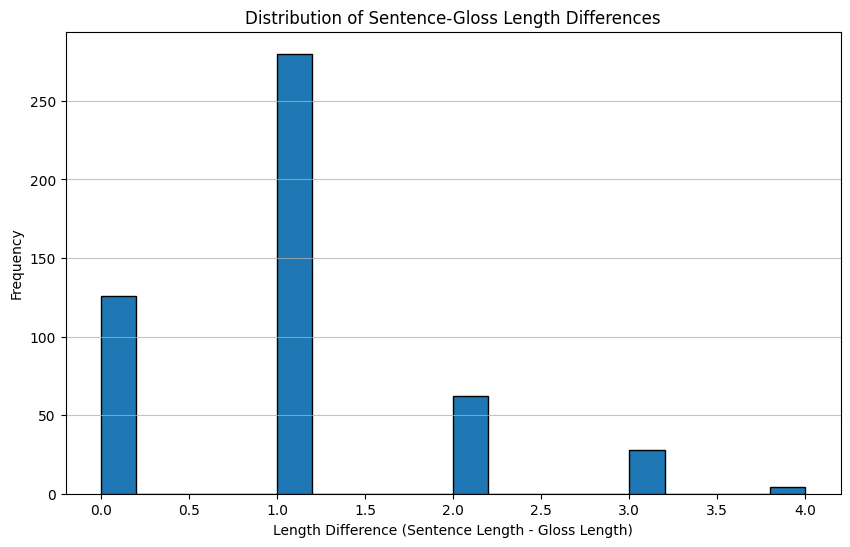

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(df['length_diff'], bins=20, edgecolor='black')
plt.title("Distribution of Sentence-Gloss Length Differences")
plt.xlabel("Length Difference (Sentence Length - Gloss Length)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

## Visualize flagged samples

### Subtask:
Create visualizations to show the distribution of flagged samples based on `has_rare_token` and `large_mismatch` columns.


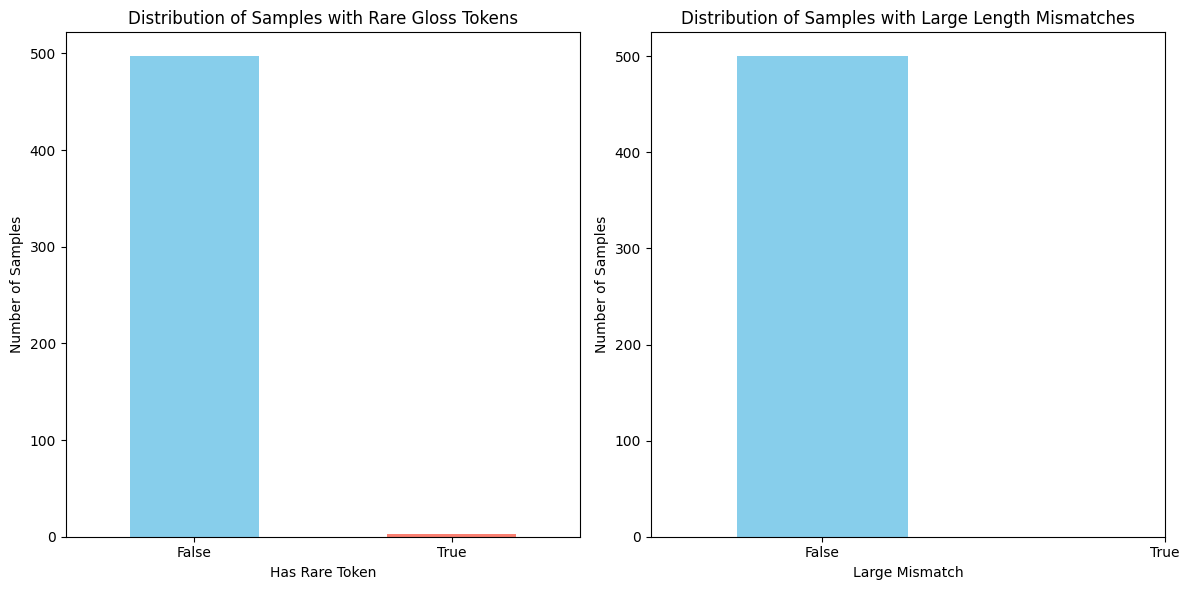

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for has_rare_token
rare_counts = df['has_rare_token'].value_counts()
rare_counts.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Distribution of Samples with Rare Gloss Tokens')
axes[0].set_xlabel('Has Rare Token')
axes[0].set_ylabel('Number of Samples')
axes[0].set_xticks([0, 1]) # Ensure ticks for both False and True
axes[0].set_xticklabels(['False', 'True'], rotation=0)

# Plot for large_mismatch
mismatch_counts = df['large_mismatch'].value_counts()
mismatch_counts.plot(kind='bar', ax=axes[1], color=['skyblue', 'salmon'])
axes[1].set_title('Distribution of Samples with Large Length Mismatches')
axes[1].set_xlabel('Large Mismatch')
axes[1].set_ylabel('Number of Samples')
axes[1].set_xticks([0, 1]) # Ensure ticks for both False and True
axes[1].set_xticklabels(['False', 'True'], rotation=0)


plt.tight_layout()
plt.show()

## Save updated flagged samples

### Subtask:
Save the updated DataFrame with the new flagging information to a new CSV file.


In [13]:
df[['Sentences', 'gloss_sequence', 'length_diff', 'has_rare_token', 'large_mismatch', 'keyword_mismatch']].to_csv('flagged_gloss_samples_updated.csv', index=False)
print("Updated flagged samples saved to 'flagged_gloss_samples_updated.csv'")

Updated flagged samples saved to 'flagged_gloss_samples_updated.csv'


## Summary:

### Data Analysis Key Findings

*   A new column `keyword_mismatch` was added to the DataFrame to indicate potential mismatches based on the absence of sentence keywords (excluding stop words) in the corresponding gloss sequence.
*   A histogram was generated to visualize the distribution of the `length_diff` column, showing the frequency of different sentence-gloss length differences.
*   Bar plots were successfully created to visualize the distribution of samples flagged with `has_rare_token` (indicating the presence of rare tokens in the gloss) and `large_mismatch` (indicating large length discrepancies).
*   An updated CSV file named `flagged_gloss_samples_updated.csv` was created, containing the original data along with the `length_diff`, `has_rare_token`, `large_mismatch`, and `keyword_mismatch` columns.

### Insights or Next Steps

*   Further investigation into samples flagged by `keyword_mismatch` and `large_mismatch` is needed to understand the nature of these potential issues and their impact on the dataset quality.
*   Analyze the samples flagged by both `has_rare_token` and other flags to identify patterns and potential sources of error in gloss generation or data collection.


## Summary:

### Data Analysis Key Findings

* A new column `keyword_mismatch` was added to the DataFrame to indicate potential mismatches based on the absence of sentence keywords (excluding stop words) in the corresponding gloss sequence.
* A histogram was generated to visualize the distribution of the `length_diff` column, showing the frequency of different sentence-gloss length differences.
* Bar plots were successfully created to visualize the distribution of samples flagged with `has_rare_token` (indicating the presence of rare tokens in the gloss) and `large_mismatch` (indicating large length discrepancies).
* An updated CSV file named `flagged_gloss_samples_updated.csv` was created, containing the original data along with the `length_diff`, `has_rare_token`, `large_mismatch`, and `keyword_mismatch` columns.

### Insights or Next Steps

* Further investigation into samples flagged by `keyword_mismatch` and `large_mismatch` is needed to understand the nature of these potential issues and their impact on the dataset quality.
* Analyze the samples flagged by both `has_rare_token` and other flags to identify patterns and potential sources of error in gloss generation or data collection.